## Visualize input audio waveform

In [1]:
import librosa
from matplotlib import pyplot as plt 

In [2]:
data, samplerate = librosa.load("./assets/audio/jfk.flac", sr=16000)

In [3]:
samplerate

16000

In [4]:
data.shape

(176000,)

In [5]:
data.shape

(176000,)

In [6]:
data.max(), data.min(), data.mean(), data.std()

(0.78274125, -0.72361434, 1.3705251e-05, 0.1421046)

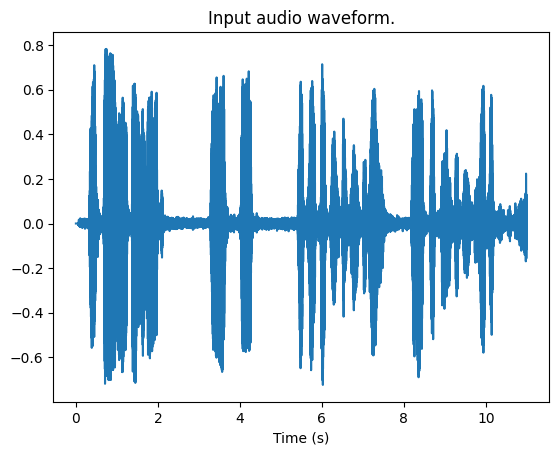

In [7]:
plt.title("Input audio waveform.")
plt.xlabel("Time (s)")
x = [i / samplerate for i in range(data.shape[0])]
plt.plot(x, data)
plt.show()

## Load model and processor

In [8]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

/Users/emiliomarinone/Personal_repos/whisper-inquiry/src/whisper_paper/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
processor = WhisperProcessor.from_pretrained("openai/whisper-large")


In [9]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")

Downloading: 100%|██████████████████████████████████████████████████████████| 1.93k/1.93k [00:00<00:00, 378kB/s]


## Visualize log-mel spectrogram

In [11]:
input_features = processor(data, return_tensors="pt").input_features

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [12]:
input_features.shape

torch.Size([1, 80, 3000])

In [13]:
input_features

tensor([[[-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         ...,
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387],
         [-0.5387, -0.5387, -0.5387,  ..., -0.5387, -0.5387, -0.5387]]])

In [14]:
input_features.max(), input_features.min(), input_features.mean(), input_features.std()

(tensor(1.4613), tensor(-0.5387), tensor(-0.2950), tensor(0.4221))

In [15]:
import torchvision.transforms as T


transform = T.ToPILImage()

In [16]:
import math


audio_duration = data.shape[0] / samplerate
log_mel_size = math.ceil(audio_duration * 100)

img = transform(input_features[:,:,:log_mel_size])
img.show()

In [17]:
img = transform(input_features)
img.show()

In [18]:
mel_spect = input_features[:,:,:log_mel_size].squeeze(0).numpy()

In [19]:
import librosa.display
import numpy as np


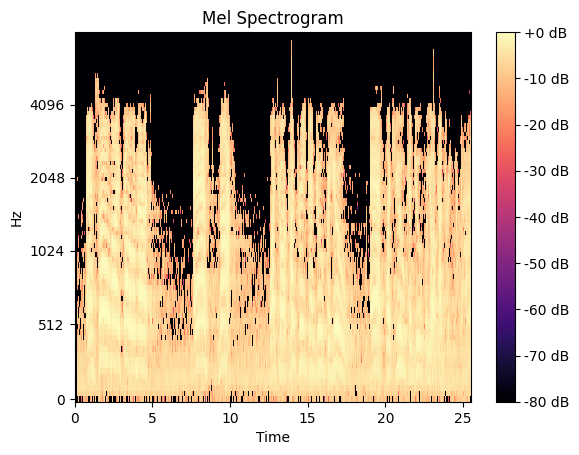

In [20]:
librosa.display.specshow(librosa.power_to_db(mel_spect, ref=np.max), y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

## Inspect tokenizer

In [22]:
original_input = "This is a tokenization example."
token_ids = processor.tokenizer.encode(original_input)
tokens = processor.tokenizer.batch_decode(token_ids)
reconstructed_input = processor.tokenizer.decode(token_ids, skip_special_tokens=True)
assert original_input == reconstructed_input, f"{original_input = } != {reconstructed_input = }"

In [23]:
original_input

'This is a tokenization example.'

In [24]:
tokens

['<|startoftranscript|>',
 '<|notimestamps|>',
 'This',
 ' is',
 ' a',
 ' ',
 't',
 'oken',
 'ization',
 ' example',
 '.',
 '<|endoftext|>']

In [25]:
token_ids

[50258, 50363, 5723, 307, 257, 220, 83, 8406, 2144, 1365, 13, 50257]

In [26]:
reconstructed_input

'This is a tokenization example.'

## Example of embedding of 5 tokens with embedding_dim = 10

In [27]:
import numpy as np


In [28]:
np.random.uniform(low=-1, size=(5,10))

array([[-0.72661343, -0.00380015,  0.59420702, -0.20719671,  0.87574917,
         0.05509076,  0.88486984,  0.14011831, -0.54456582,  0.86226079],
       [ 0.94114731, -0.98093481, -0.59462445, -0.59808612, -0.82133542,
         0.72431221,  0.53077191,  0.08137058, -0.0240524 , -0.20938785],
       [-0.15078345, -0.12959009,  0.88418577, -0.92178346,  0.65415046,
         0.97619017, -0.4434792 ,  0.64908836, -0.76030552,  0.33084692],
       [-0.77542453, -0.59691642, -0.20359321, -0.26304013, -0.04247581,
         0.77033624,  0.52936677,  0.1303209 ,  0.48992639,  0.24048335],
       [-0.43631284,  0.39280121,  0.80035716, -0.49053885, -0.53011963,
        -0.99233524,  0.00444794, -0.93367312, -0.79154283,  0.69892671]])

## Whisper's convolutional layers

In [29]:
from torch.nn.functional import gelu

In [30]:
conv_1_output = gelu(model.model.encoder.conv1(input_features))


In [31]:
conv_1_output.shape

torch.Size([1, 1280, 3000])

In [32]:
conv_1_output.max(), conv_1_output.min(), conv_1_output.mean(), conv_1_output.std()

(tensor(3.2739, grad_fn=<MaxBackward1>),
 tensor(-0.1700, grad_fn=<MinBackward1>),
 tensor(0.0388, grad_fn=<MeanBackward0>),
 tensor(0.0838, grad_fn=<StdBackward0>))

In [33]:
conv_2_output = gelu(model.model.encoder.conv2(conv_1_output))
conv_2_output.shape

torch.Size([1, 1280, 1500])

In [34]:
conv_2_output.max(), conv_2_output.min(), conv_2_output.mean(), conv_2_output.std()

(tensor(8.1401, grad_fn=<MaxBackward1>),
 tensor(-0.1700, grad_fn=<MinBackward1>),
 tensor(0.2311, grad_fn=<MeanBackward0>),
 tensor(0.4213, grad_fn=<StdBackward0>))

In [35]:
input_embeds = conv_2_output

In [36]:
model.model.encoder.embed_positions

Embedding(1500, 1280)

In [37]:
embed_pos = model.model.encoder.embed_positions.weight
embed_pos.shape

torch.Size([1500, 1280])

In [38]:
img = transform(embed_pos)
img.show()

In [39]:
embed_pos.max(), embed_pos.min(), embed_pos.mean(), embed_pos.std()

(tensor(1., grad_fn=<MaxBackward1>),
 tensor(-1., grad_fn=<MinBackward1>),
 tensor(0.2074, grad_fn=<MeanBackward0>),
 tensor(0.6760, grad_fn=<StdBackward0>))

In [40]:
inputs_embeds = input_embeds.permute(0, 2, 1)

In [41]:
inputs_embeds.shape

torch.Size([1, 1500, 1280])

In [42]:
inputs_embeds = inputs_embeds + embed_pos

In [43]:
inputs_embeds.shape

torch.Size([1, 1500, 1280])

In [44]:
inputs_embeds.max(), inputs_embeds.min(), inputs_embeds.mean(), inputs_embeds.std()

(tensor(8.9507, grad_fn=<MaxBackward1>),
 tensor(-1.1700, grad_fn=<MinBackward1>),
 tensor(0.4385, grad_fn=<MeanBackward0>),
 tensor(0.7709, grad_fn=<StdBackward0>))

## Whisper's embedding

In [45]:
import torch

In [46]:
t = torch.tensor(token_ids)
t

tensor([50258, 50363,  5723,   307,   257,   220,    83,  8406,  2144,  1365,
           13, 50257])

In [47]:
t.shape

torch.Size([12])

In [48]:
embeddings = model.model.decoder.embed_tokens(t)
embeddings

tensor([[-0.0018, -0.0024, -0.0094,  ..., -0.0071,  0.0026,  0.0061],
        [ 0.0036,  0.0079,  0.0042,  ..., -0.0011,  0.0098, -0.0016],
        [-0.0014, -0.0077,  0.0017,  ..., -0.0049,  0.0080,  0.0095],
        ...,
        [-0.0026, -0.0127, -0.0026,  ..., -0.0009,  0.0128,  0.0120],
        [ 0.0052,  0.0261,  0.0241,  ...,  0.0053, -0.0057, -0.0072],
        [ 0.0002,  0.0042, -0.0034,  ...,  0.0047,  0.0086, -0.0005]],
       grad_fn=<EmbeddingBackward0>)

In [49]:
embeddings.shape

torch.Size([12, 1280])

## Inspect "task" tokens

In [50]:
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe", no_timestamps=True)

In [51]:
decoder_input = model.config.forced_decoder_ids
decoder_input

[(1, 50259), (2, 50359), (3, 50363)]

In [52]:
[processor.tokenizer.decode(kv[1]) for kv in decoder_input]

['<|en|>', '<|transcribe|>', '<|notimestamps|>']

In [55]:
decoder_input_values = [kv[1] for kv in decoder_input]
decoder_input_values

[50259, 50359, 50363]

In [56]:
processor.batch_decode(decoder_input_values)

['<|en|>', '<|transcribe|>', '<|notimestamps|>']

## Transcribe

In [57]:
resp = model.generate(
    input_features,
    do_sample=True,
    num_return_sequences=1,
    num_beams=1,
    num_beam_groups=1
)

/Users/emiliomarinone/Personal_repos/whisper-inquiry/src/whisper_paper/venv/lib/python3.8/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [58]:
resp.shape

torch.Size([1, 31])

In [59]:
resp

tensor([[50258, 50259, 50359, 50363,   400,   370,    11,   452,  7177,  6280,
            11,  1029,   406,   437,   428,  1941,   393,   360,   337,   291,
            11,  1029,   437,   291,   393,   360,   337,   428,  1941,    13,
         50257]])

In [60]:
resp[0].shape

torch.Size([31])

In [61]:
[processor.tokenizer.decode(token) for token in resp[0]]

['<|startoftranscript|>',
 '<|en|>',
 '<|transcribe|>',
 '<|notimestamps|>',
 ' And',
 ' so',
 ',',
 ' my',
 ' fellow',
 ' Americans',
 ',',
 ' ask',
 ' not',
 ' what',
 ' your',
 ' country',
 ' can',
 ' do',
 ' for',
 ' you',
 ',',
 ' ask',
 ' what',
 ' you',
 ' can',
 ' do',
 ' for',
 ' your',
 ' country',
 '.',
 '<|endoftext|>']

In [62]:
processor.decode(resp[0])

'<|startoftranscript|><|en|><|transcribe|><|notimestamps|> And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.<|endoftext|>'

In [63]:
processor.decode(resp[0], skip_special_tokens=True)

' And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.'

In [64]:
processor.decode(resp[0], skip_special_tokens=True).strip()

'And so, my fellow Americans, ask not what your country can do for you, ask what you can do for your country.'